In [6]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile


import cv2

In [7]:
#https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
path_to_zip_file = "/Users/user/data/train-test-data.zip"
directory_to_extract_to = "/Users/user/data"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()

In [18]:
key_points_frame = pd.read_csv('train-test-data/training_frames_keypoints.csv')
n = 0

def get_image_name_points(index):
    image_name = key_points_frame.iloc[0, index]
    points = key_points_frame.iloc[n, 1:].as_matrix()
    points = points.astype('float').reshape(-1, 2)

    return image_name, points

In [19]:
def show_keypoints(image, key_points):
    plt.imshow(image)
    plt.scatter(key_points[:, 0], key_points[:, 1], s=20, marker='.', c='m')

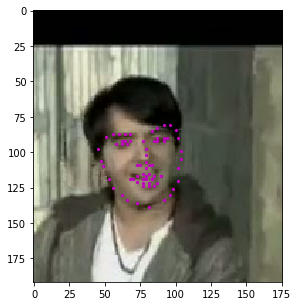

In [20]:
index = 0

plt.figure(figsize = (5,5))
image_name, points = get_image_name_points(index)
path = '/Users/user/data/train-test-data/training/' + image_name
image = mpimg.imread(path)
show_keypoints(image, points)


In [5]:
from FacePointsDataset import FacePointsDataset

face_dataset = FacePointsDataset(csv_file='train-test-data/training_frames_keypoints.csv',
                                      root_dir='train-test-data/training')
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


In [3]:
for i in range(3):
    
    fig = plt.figure(figsize=(20,10))    
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, 3, i + 1)
    ax.set_title('Sample #{}'.format(i))    
    show_keypoints(sample['image'], sample['keypoints'])

NameError: name 'plt' is not defined

In [24]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        key_pts_copy = (key_pts_copy - 100)/50.0
        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = cv2.resize(image, (new_w, new_h))        
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        if(len(image.shape) == 2):
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

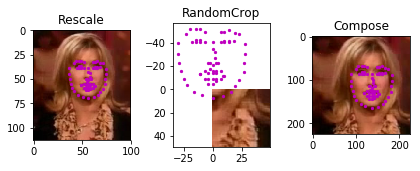

In [29]:
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()